In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, random_split
import torch
from torch import optim
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import logging
from evaluate import evaluate
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import OrderedDict

#from model.unet.unet_model import UNet
#from model.segnet.segnet_model import SegNet
#from torchvision.models.segmentation import deeplabv3_resnet101 as DeepLabv3
from model.ensemblenet_model import EnsembleNet


from utils.dice_score import dice_loss
from utils.data_load import KittiDataset
from torchsummaryX import summary

In [2]:
Val_Percent = 0.3
Scale_Percent = 1.0
Batch_Size = 8
learning_rate = 0.0001
Pin_Memory = False
epochs = 50

#Image_Size = [384, 1242]
Image_Size = [384, 1216]
#Image_Size = [384,384]
Gradient_Clipping = 0.8

#Num_Class = 31
#Num_Class = 21
Num_Class = 2
Num_Channel = 3
amp = True

Model_Name = 'ensemble_fusion'


Img_Path =  'data/data_road/training/image_2'
Mask_Path =  'data/data_road/training/semantic'

save_checkpoint = False
checkpoint_dir = '../trained'
batch_size = Batch_Size

In [3]:
dirImg = Path(Img_Path)
dirMask = Path(Mask_Path)

dir_checkpoint = Path(checkpoint_dir)

train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        #A.RandomGamma(p=0.5),
        #A.RandomSnow(p=0.5),
        #A.RandomRain(p=0.5),
        #A.RandomFog(p=0.5),
        #A.RandomSunFlare(p=0.5),
        A.RandomShadow(p=0.5),
        #A.RandomToneCurve(p=0.5),
        #A.GaussNoise(p=0.5),
        #A.Emboss(p=0.5),  # IAAEmboss 대신 Emboss 사용
        #A.Perspective(p=0.5),  # IAAPerspective 대신 Perspective 사용
        #A.CLAHE(p=0.5)
])

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent)
#datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent, train_transform)
n_val = int(len(datasets) * Val_Percent)
n_train = len(datasets) - n_val
train_set, val_set = random_split(datasets, [n_train, n_val], generator=torch.Generator().manual_seed(0))

loader_args = dict(batch_size=Batch_Size, num_workers= os.cpu_count(), pin_memory=Pin_Memory)
train_loader = DataLoader(train_set, shuffle=True, drop_last = True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

100%|██████████| 289/289 [00:00<00:00, 936.33it/s]


In [6]:
model = EnsembleNet(Model_Name, Num_Channel, Num_Class)
model = model.to(memory_format=torch.channels_last, device = device)

In [7]:
# 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)

if 'ensemble_voting' in Model_Name:
    unet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    segnet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    enet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    voting_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    
else:
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score

grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss()
global_step = 0

In [8]:
def calculate_loss(pred, true_masks, nclass, multiclass):
    loss = criterion(pred, true_masks)
    loss += dice_loss(
        F.softmax(pred, dim=1).float(),
        F.one_hot(true_masks, nclass).permute(0, 3, 1, 2).float(),
        multiclass=multiclass
    )
    return loss


def forward_and_backward(model, images, true_masks, amp, optimizer, grad_scaler, model_name):
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        if model_name == 'ensemble_voting':
            unet_pred, segnet_pred, enet_pred = model(images)
            #deeplab_pred = deeplab_pred['out']
        else:
            masks_pred = model(images)
            if isinstance(masks_pred, OrderedDict):
                masks_pred = masks_pred['out']

        try:
            mn_cls = model.n_classes
        except:
            mn_cls = model.classifier[-1].out_channels


        if model_name == 'ensemble_voting':
            unet_loss = calculate_loss(unet_pred, true_masks, mn_cls, multiclass=True)
            segnet_loss = calculate_loss(segnet_pred, true_masks, mn_cls, multiclass=True)
            enet_loss = calculate_loss(enet_pred, true_masks, mn_cls, multiclass=True)
            
        else:
            loss = calculate_loss(masks_pred, true_masks, mn_cls, multiclass=True)

    
    optimizer.zero_grad(set_to_none=True)
    if model_name == 'ensemble_voting':
        for pred, loss in zip([unet_pred, segnet_pred, enet_pred], [unet_loss, segnet_loss, enet_loss]):
            grad_scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), Gradient_Clipping)
            grad_scaler.step(optimizer)
            grad_scaler.update()
        
        return model, unet_loss, segnet_loss, enet_loss
    else:
        optimizer.zero_grad(set_to_none=True)
        grad_scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), Gradient_Clipping)
        grad_scaler.step(optimizer)
        grad_scaler.update()
        
        return model, loss


In [9]:
valScore_list1 = []
TrainLoss_list1 = []

valScore_list2 = []
TrainLoss_list2 = []

valScore_list3 = []
TrainLoss_list3 = []

valScore_list4 = []
TrainLoss_list4 = []

val_losses = []
val_accs = []
val_mious = []

# 5. Begin training
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    epoch_unet_loss = 0
    epoch_segnet_loss = 0
    epoch_enet_loss = 0
    epoch_voting_loss = 0
    
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            images, true_masks = batch['image'], batch['mask']

            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            true_masks = true_masks.to(device=device, dtype=torch.long)

                
            result = forward_and_backward(model, images, true_masks, amp, optimizer, grad_scaler, Model_Name)
            
            if len(result) == 4:
                model, unet_loss, segnet_loss, enet_loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_unet_loss += unet_loss.item()
                epoch_segnet_loss += segnet_loss.item()
                epoch_enet_loss += enet_loss.item()
                vot_loss = ((unet_loss.item() + segnet_loss.item() + enet_loss.item()) /3)
                epoch_voting_loss += vot_loss
                
                
            elif len(result) == 2:
                model, loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()


        print('***')
        if len(result) == 4:
            print('Unet Loss: {}     Segnet Loss: {}     Enet Loss: {}'.format(unet_loss, segnet_loss, enet_loss))
            print('Voting Loss: {}'.format(vot_loss))
            
            
        elif len(result) == 2:
            print('{} Loss: {}'.format(Model_Name, loss))

        # Evaluation round
        division_step = (n_train // (5 * batch_size))
        if division_step > 0:
            #if global_step % division_step == 0:
            if len(result) == 4:
                unet_val_score, segnet_val_score, enet_val_score, voting_val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                unet_scheduler.step(unet_val_score)
                segnet_scheduler.step(segnet_val_score)
                enet_scheduler.step(enet_val_score)
                voting_scheduler.step(voting_val_score)
                
                valScore_list1.append(unet_val_score)
                TrainLoss_list1.append(unet_loss)
                valScore_list2.append(segnet_val_score)
                TrainLoss_list2.append(segnet_loss)                
                valScore_list3.append(enet_val_score)
                TrainLoss_list3.append(enet_loss)
                valScore_list4.append(voting_val_score)
                TrainLoss_list4.append(vot_loss)
                
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)
                
                print('---')
                print('Unet Validation Dice Score: {}     Segnet Validation Dice Score: {}     Enet Validation Dice Score: {}'.format(unet_val_score, segnet_val_score, enet_val_score))
                
                print('Ensemble Voting Validation Dice Loss: {}'.format(val_loss))
                print('Ensemble Voting Validation Pixel Accuracy: {} '.format(val_acc))
                print('Ensemble Voting Validation MIoU: {}'.format(val_miou))                
                print('Ensemble Voting Validation Dice Score: {} '.format(voting_val_score))
                
            else:
                val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                
                
                scheduler.step(val_score)
                
                print('---')
                print('{} Validation Dice Loss: {}'.format(Model_Name, val_loss))   
                print('{} Validation Pixel Accuracy: {}'.format(Model_Name, val_acc))
                print('{} Validation MIoU: {}'.format(Model_Name, val_miou))
                print('{} Validation Dice Score: {}'.format(Model_Name, val_score))
                
            
                valScore_list1.append(val_score.cpu().detach().numpy())
                TrainLoss_list1.append(loss.cpu().detach().numpy())
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)

                #valScore_list.append(val_score)
                #TrainLoss_list.append(loss)
                #print('Validation Dice score: {}'.format(val_score))
                                
        
    if save_checkpoint:
        Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch + 1)))

Epoch 1/50:  99%|█████████▊| 200/203 [00:18<00:00, 15.82img/s]

***
ensemble_fusion Loss: 0.4825875759124756


Epoch 1/50:  99%|█████████▊| 200/203 [00:21<00:00,  9.17img/s]


---
ensemble_fusion Validation Dice Loss: 1.5982062816619873
ensemble_fusion Validation Pixel Accuracy: 0.277914749948602
ensemble_fusion Validation MIoU: 0.16126477455535337
ensemble_fusion Validation Dice Score: 0.3324805498123169


Epoch 2/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.90img/s]

***
ensemble_fusion Loss: 0.3123372197151184


Epoch 2/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.96img/s]


---
ensemble_fusion Validation Dice Loss: 0.7193504571914673
ensemble_fusion Validation Pixel Accuracy: 0.883401168020148
ensemble_fusion Validation MIoU: 0.7100267181472997
ensemble_fusion Validation Dice Score: 0.7527949213981628


Epoch 3/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.68img/s]

***
ensemble_fusion Loss: 0.26915621757507324


Epoch 3/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.90img/s]


---
ensemble_fusion Validation Dice Loss: 0.3673721253871918
ensemble_fusion Validation Pixel Accuracy: 0.9245677747224507
ensemble_fusion Validation MIoU: 0.7756947078307037
ensemble_fusion Validation Dice Score: 0.7930513024330139


Epoch 4/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.87img/s]

***
ensemble_fusion Loss: 0.23214471340179443


Epoch 4/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.92img/s]


---
ensemble_fusion Validation Dice Loss: 0.29659974575042725
ensemble_fusion Validation Pixel Accuracy: 0.9319950572231359
ensemble_fusion Validation MIoU: 0.7528739593470819
ensemble_fusion Validation Dice Score: 0.7381648421287537


Epoch 5/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.70img/s]

***
ensemble_fusion Loss: 0.2103743702173233


Epoch 5/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.88img/s]


---
ensemble_fusion Validation Dice Loss: 0.21426057815551758
ensemble_fusion Validation Pixel Accuracy: 0.9518357661732456
ensemble_fusion Validation MIoU: 0.8382526529208592
ensemble_fusion Validation Dice Score: 0.8224948048591614


Epoch 6/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.91img/s]

***
ensemble_fusion Loss: 0.1788654625415802


Epoch 6/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.93img/s]


---
ensemble_fusion Validation Dice Loss: 0.35652661323547363
ensemble_fusion Validation Pixel Accuracy: 0.9112945021244517
ensemble_fusion Validation MIoU: 0.6639823383963468
ensemble_fusion Validation Dice Score: 0.430682510137558


Epoch 7/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.87img/s]

***
ensemble_fusion Loss: 0.15521419048309326


Epoch 7/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.63img/s]


---
ensemble_fusion Validation Dice Loss: 0.27512872219085693
ensemble_fusion Validation Pixel Accuracy: 0.9250140273780153
ensemble_fusion Validation MIoU: 0.7128772759572983
ensemble_fusion Validation Dice Score: 0.5482160449028015


Epoch 8/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.72img/s]

***
ensemble_fusion Loss: 0.145004004240036


Epoch 8/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.83img/s]


---
ensemble_fusion Validation Dice Loss: 0.1630192995071411
ensemble_fusion Validation Pixel Accuracy: 0.9606347335012335
ensemble_fusion Validation MIoU: 0.8563037061900338
ensemble_fusion Validation Dice Score: 0.8611118197441101


Epoch 9/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.87img/s]

***
ensemble_fusion Loss: 0.1548297107219696


Epoch 9/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.73img/s]


---
ensemble_fusion Validation Dice Loss: 0.31888359785079956
ensemble_fusion Validation Pixel Accuracy: 0.928189193993284
ensemble_fusion Validation MIoU: 0.7271012483328133
ensemble_fusion Validation Dice Score: 0.5883825421333313


Epoch 10/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.71img/s]

***
ensemble_fusion Loss: 0.09833076596260071


Epoch 10/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.80img/s]


---
ensemble_fusion Validation Dice Loss: 0.0985405221581459
ensemble_fusion Validation Pixel Accuracy: 0.978977404142681
ensemble_fusion Validation MIoU: 0.9211669517481216
ensemble_fusion Validation Dice Score: 0.8841949701309204


Epoch 11/50:  99%|█████████▊| 200/203 [00:14<00:00, 16.01img/s]

***
ensemble_fusion Loss: 0.2012212723493576


Epoch 11/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.97img/s]


---
ensemble_fusion Validation Dice Loss: 0.2587137520313263
ensemble_fusion Validation Pixel Accuracy: 0.939487658048931
ensemble_fusion Validation MIoU: 0.8154153649709264
ensemble_fusion Validation Dice Score: 0.8584162592887878


Epoch 12/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.83img/s]

***
ensemble_fusion Loss: 0.08740846812725067


Epoch 12/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.76img/s]


---
ensemble_fusion Validation Dice Loss: 0.15963909029960632
ensemble_fusion Validation Pixel Accuracy: 0.9615925571374726
ensemble_fusion Validation MIoU: 0.8541503721514567
ensemble_fusion Validation Dice Score: 0.8236609697341919


Epoch 13/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.76img/s]

***
ensemble_fusion Loss: 0.08800278604030609


Epoch 13/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.91img/s]


---
ensemble_fusion Validation Dice Loss: 0.11117619276046753
ensemble_fusion Validation Pixel Accuracy: 0.9755725525973136
ensemble_fusion Validation MIoU: 0.9105866954934199
ensemble_fusion Validation Dice Score: 0.9220002293586731


Epoch 14/50:  99%|█████████▊| 200/203 [00:14<00:00, 16.00img/s]

***
ensemble_fusion Loss: 0.12066655606031418


Epoch 14/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.76img/s]


---
ensemble_fusion Validation Dice Loss: 0.15483632683753967
ensemble_fusion Validation Pixel Accuracy: 0.9593409488075658
ensemble_fusion Validation MIoU: 0.8651024694767099
ensemble_fusion Validation Dice Score: 0.8953548669815063


Epoch 15/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.80img/s]

***
ensemble_fusion Loss: 0.1371508538722992


Epoch 15/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.77img/s]


---
ensemble_fusion Validation Dice Loss: 0.09275135397911072
ensemble_fusion Validation Pixel Accuracy: 0.9790740431400767
ensemble_fusion Validation MIoU: 0.9235398089055041
ensemble_fusion Validation Dice Score: 0.9172383546829224


Epoch 16/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.94img/s]

***
ensemble_fusion Loss: 0.08354230970144272


Epoch 16/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.77img/s]


---
ensemble_fusion Validation Dice Loss: 0.10010556876659393
ensemble_fusion Validation Pixel Accuracy: 0.9761363246984649
ensemble_fusion Validation MIoU: 0.9138784379544895
ensemble_fusion Validation Dice Score: 0.9130117297172546


Epoch 17/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.91img/s]

***
ensemble_fusion Loss: 0.08380962908267975


Epoch 17/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.89img/s]


---
ensemble_fusion Validation Dice Loss: 0.0959380716085434
ensemble_fusion Validation Pixel Accuracy: 0.9762353729783443
ensemble_fusion Validation MIoU: 0.9126007134219287
ensemble_fusion Validation Dice Score: 0.9203053712844849


Epoch 18/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.73img/s]

***
ensemble_fusion Loss: 0.07772530615329742


Epoch 18/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.91img/s]


---
ensemble_fusion Validation Dice Loss: 0.08059825003147125
ensemble_fusion Validation Pixel Accuracy: 0.9801357336211622
ensemble_fusion Validation MIoU: 0.926619313148807
ensemble_fusion Validation Dice Score: 0.927363395690918


Epoch 19/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.64img/s]

***
ensemble_fusion Loss: 0.06021649017930031


Epoch 19/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.88img/s]


---
ensemble_fusion Validation Dice Loss: 0.08848626166582108
ensemble_fusion Validation Pixel Accuracy: 0.9784960830420778
ensemble_fusion Validation MIoU: 0.9192560987719554
ensemble_fusion Validation Dice Score: 0.920534074306488


Epoch 20/50:  99%|█████████▊| 200/203 [00:14<00:00, 16.04img/s]

***
ensemble_fusion Loss: 0.0603216290473938


Epoch 20/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.85img/s]


---
ensemble_fusion Validation Dice Loss: 0.07767005264759064
ensemble_fusion Validation Pixel Accuracy: 0.9814734207956415
ensemble_fusion Validation MIoU: 0.931873423310839
ensemble_fusion Validation Dice Score: 0.9306805729866028


Epoch 21/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.92img/s]

***
ensemble_fusion Loss: 0.05547676980495453


Epoch 21/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.92img/s]


---
ensemble_fusion Validation Dice Loss: 0.07295814901590347
ensemble_fusion Validation Pixel Accuracy: 0.9820829692639803
ensemble_fusion Validation MIoU: 0.9334671539525307
ensemble_fusion Validation Dice Score: 0.932344377040863


Epoch 22/50:  99%|█████████▊| 200/203 [00:14<00:00, 16.05img/s]

***
ensemble_fusion Loss: 0.04469653218984604


Epoch 22/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.84img/s]


---
ensemble_fusion Validation Dice Loss: 0.08539436012506485
ensemble_fusion Validation Pixel Accuracy: 0.9792416221217105
ensemble_fusion Validation MIoU: 0.92512689838871
ensemble_fusion Validation Dice Score: 0.93147212266922


Epoch 23/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.83img/s]

***
ensemble_fusion Loss: 0.035625435411930084


Epoch 23/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.69img/s]


---
ensemble_fusion Validation Dice Loss: 0.07124921679496765
ensemble_fusion Validation Pixel Accuracy: 0.9828598290158991
ensemble_fusion Validation MIoU: 0.9364719243424438
ensemble_fusion Validation Dice Score: 0.9338932037353516


Epoch 24/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.81img/s]

***
ensemble_fusion Loss: 0.04444924741983414


Epoch 24/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.92img/s]


---
ensemble_fusion Validation Dice Loss: 0.07426236569881439
ensemble_fusion Validation Pixel Accuracy: 0.9818444502981085
ensemble_fusion Validation MIoU: 0.9332481765421183
ensemble_fusion Validation Dice Score: 0.934571385383606


Epoch 25/50:  99%|█████████▊| 200/203 [00:14<00:00, 16.07img/s]

***
ensemble_fusion Loss: 0.0424511581659317


Epoch 25/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.93img/s]


---
ensemble_fusion Validation Dice Loss: 0.0775686651468277
ensemble_fusion Validation Pixel Accuracy: 0.9808025694729989
ensemble_fusion Validation MIoU: 0.9290591997669277
ensemble_fusion Validation Dice Score: 0.9295570254325867


Epoch 26/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.85img/s]

***
ensemble_fusion Loss: 0.042254313826560974


Epoch 26/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.90img/s]


---
ensemble_fusion Validation Dice Loss: 0.07166532427072525
ensemble_fusion Validation Pixel Accuracy: 0.9825680381373355
ensemble_fusion Validation MIoU: 0.9354308541443761
ensemble_fusion Validation Dice Score: 0.9348875880241394


Epoch 27/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.86img/s]

***
ensemble_fusion Loss: 0.04923706874251366


Epoch 27/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.75img/s]


---
ensemble_fusion Validation Dice Loss: 0.0812319666147232
ensemble_fusion Validation Pixel Accuracy: 0.9797486422354715
ensemble_fusion Validation MIoU: 0.9269911253033467
ensemble_fusion Validation Dice Score: 0.9336568713188171


Epoch 28/50:  99%|█████████▊| 200/203 [00:14<00:00, 16.00img/s]

***
ensemble_fusion Loss: 0.03847752511501312


Epoch 28/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.96img/s]


---
ensemble_fusion Validation Dice Loss: 0.07689569890499115
ensemble_fusion Validation Pixel Accuracy: 0.9804639314350329
ensemble_fusion Validation MIoU: 0.9279645819421354
ensemble_fusion Validation Dice Score: 0.9322506785392761


Epoch 29/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.74img/s]

***
ensemble_fusion Loss: 0.0465039387345314


Epoch 29/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.81img/s]


---
ensemble_fusion Validation Dice Loss: 0.07323110103607178
ensemble_fusion Validation Pixel Accuracy: 0.9818307976973685
ensemble_fusion Validation MIoU: 0.9331831587265784
ensemble_fusion Validation Dice Score: 0.9349546432495117


Epoch 30/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.87img/s]

***
ensemble_fusion Loss: 0.04373607784509659


Epoch 30/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.73img/s]


---
ensemble_fusion Validation Dice Loss: 0.08172488212585449
ensemble_fusion Validation Pixel Accuracy: 0.9793805574115954
ensemble_fusion Validation MIoU: 0.9255486953268977
ensemble_fusion Validation Dice Score: 0.9360756874084473


Epoch 31/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.86img/s]

***
ensemble_fusion Loss: 0.03478841111063957


Epoch 31/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.87img/s]


---
ensemble_fusion Validation Dice Loss: 0.08661694824695587
ensemble_fusion Validation Pixel Accuracy: 0.9784136320415296
ensemble_fusion Validation MIoU: 0.9227340425567675
ensemble_fusion Validation Dice Score: 0.9353410601615906


Epoch 32/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.78img/s]

***
ensemble_fusion Loss: 0.03508222848176956


Epoch 32/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.83img/s]


---
ensemble_fusion Validation Dice Loss: 0.08561812341213226
ensemble_fusion Validation Pixel Accuracy: 0.9782658627158717
ensemble_fusion Validation MIoU: 0.9222471294920982
ensemble_fusion Validation Dice Score: 0.934910237789154


Epoch 33/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.79img/s]

***
ensemble_fusion Loss: 0.03534824401140213


Epoch 33/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.87img/s]


---
ensemble_fusion Validation Dice Loss: 0.07846580445766449
ensemble_fusion Validation Pixel Accuracy: 0.9804114626165021
ensemble_fusion Validation MIoU: 0.9290165071126064
ensemble_fusion Validation Dice Score: 0.9365370869636536


Epoch 34/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.79img/s]

***
ensemble_fusion Loss: 0.03956083953380585


Epoch 34/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.81img/s]


---
ensemble_fusion Validation Dice Loss: 0.07869671285152435
ensemble_fusion Validation Pixel Accuracy: 0.9805696721662555
ensemble_fusion Validation MIoU: 0.9294987517294917
ensemble_fusion Validation Dice Score: 0.9363533854484558


Epoch 35/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.77img/s]

***
ensemble_fusion Loss: 0.04018166661262512


Epoch 35/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.90img/s]


---
ensemble_fusion Validation Dice Loss: 0.07276121526956558
ensemble_fusion Validation Pixel Accuracy: 0.9823616429379112
ensemble_fusion Validation MIoU: 0.9352766903628109
ensemble_fusion Validation Dice Score: 0.936782956123352


Epoch 36/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.91img/s]

***
ensemble_fusion Loss: 0.03807036206126213


Epoch 36/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.75img/s]


---
ensemble_fusion Validation Dice Loss: 0.07483455538749695
ensemble_fusion Validation Pixel Accuracy: 0.9816088760108278
ensemble_fusion Validation MIoU: 0.9327822061606539
ensemble_fusion Validation Dice Score: 0.9364235997200012


Epoch 37/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.72img/s]

***
ensemble_fusion Loss: 0.035619162023067474


Epoch 37/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.72img/s]


---
ensemble_fusion Validation Dice Loss: 0.07758413255214691
ensemble_fusion Validation Pixel Accuracy: 0.9804872211657072
ensemble_fusion Validation MIoU: 0.9291758792930792
ensemble_fusion Validation Dice Score: 0.9362937808036804


Epoch 38/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.75img/s]

***
ensemble_fusion Loss: 0.02834382653236389


Epoch 38/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.83img/s]


---
ensemble_fusion Validation Dice Loss: 0.08722176402807236
ensemble_fusion Validation Pixel Accuracy: 0.9779981646621436
ensemble_fusion Validation MIoU: 0.9214113432159068
ensemble_fusion Validation Dice Score: 0.9348474740982056


Epoch 39/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.77img/s]

***
ensemble_fusion Loss: 0.08590607345104218


Epoch 39/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.82img/s]


---
ensemble_fusion Validation Dice Loss: 0.07279816269874573
ensemble_fusion Validation Pixel Accuracy: 0.9822791919373629
ensemble_fusion Validation MIoU: 0.9350353108004992
ensemble_fusion Validation Dice Score: 0.9368778467178345


Epoch 40/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.79img/s]

***
ensemble_fusion Loss: 0.03862864524126053


Epoch 40/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.89img/s]


---
ensemble_fusion Validation Dice Loss: 0.07963709533214569
ensemble_fusion Validation Pixel Accuracy: 0.9801373398094847
ensemble_fusion Validation MIoU: 0.9280347324338099
ensemble_fusion Validation Dice Score: 0.9365407824516296


Epoch 41/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.82img/s]

***
ensemble_fusion Loss: 0.03736605867743492


Epoch 41/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.87img/s]


---
ensemble_fusion Validation Dice Loss: 0.08152627944946289
ensemble_fusion Validation Pixel Accuracy: 0.9797467683490954
ensemble_fusion Validation MIoU: 0.9269541074480632
ensemble_fusion Validation Dice Score: 0.9356824159622192


Epoch 42/50:  99%|█████████▊| 200/203 [00:14<00:00, 16.05img/s]

***
ensemble_fusion Loss: 0.040928490459918976


Epoch 42/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.76img/s]


---
ensemble_fusion Validation Dice Loss: 0.08230965584516525
ensemble_fusion Validation Pixel Accuracy: 0.9793709202816612
ensemble_fusion Validation MIoU: 0.9257586606978434
ensemble_fusion Validation Dice Score: 0.935590922832489


Epoch 43/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.95img/s]

***
ensemble_fusion Loss: 0.03908255696296692


Epoch 43/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.92img/s]


---
ensemble_fusion Validation Dice Loss: 0.07984714210033417
ensemble_fusion Validation Pixel Accuracy: 0.9798798142817983
ensemble_fusion Validation MIoU: 0.9273343471158031
ensemble_fusion Validation Dice Score: 0.9363686442375183


Epoch 44/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.80img/s]

***
ensemble_fusion Loss: 0.04141905903816223


Epoch 44/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.95img/s]


---
ensemble_fusion Validation Dice Loss: 0.08124864846467972
ensemble_fusion Validation Pixel Accuracy: 0.9797660426089638
ensemble_fusion Validation MIoU: 0.9269377301598785
ensemble_fusion Validation Dice Score: 0.9361512064933777


Epoch 45/50:  99%|█████████▊| 200/203 [00:14<00:00, 16.00img/s]

***
ensemble_fusion Loss: 0.0360880121588707


Epoch 45/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.85img/s]


---
ensemble_fusion Validation Dice Loss: 0.07990650087594986
ensemble_fusion Validation Pixel Accuracy: 0.9797036689624452
ensemble_fusion Validation MIoU: 0.926691811296633
ensemble_fusion Validation Dice Score: 0.9364367723464966


Epoch 46/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.90img/s]

***
ensemble_fusion Loss: 0.03668810799717903


Epoch 46/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.66img/s]


---
ensemble_fusion Validation Dice Loss: 0.08391986787319183
ensemble_fusion Validation Pixel Accuracy: 0.979113127055921
ensemble_fusion Validation MIoU: 0.9249742273094881
ensemble_fusion Validation Dice Score: 0.9354063868522644


Epoch 47/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.85img/s]

***
ensemble_fusion Loss: 0.03739263117313385


Epoch 47/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.74img/s]


---
ensemble_fusion Validation Dice Loss: 0.07694977521896362
ensemble_fusion Validation Pixel Accuracy: 0.9806711297286185
ensemble_fusion Validation MIoU: 0.929815449604193
ensemble_fusion Validation Dice Score: 0.9367233514785767


Epoch 48/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.69img/s]

***
ensemble_fusion Loss: 0.04414081573486328


Epoch 48/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.78img/s]


---
ensemble_fusion Validation Dice Loss: 0.08401727676391602
ensemble_fusion Validation Pixel Accuracy: 0.9788668448464912
ensemble_fusion Validation MIoU: 0.924177475316796
ensemble_fusion Validation Dice Score: 0.9353018999099731


Epoch 49/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.73img/s]

***
ensemble_fusion Loss: 0.03995776176452637


Epoch 49/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.77img/s]


---
ensemble_fusion Validation Dice Loss: 0.09060217440128326
ensemble_fusion Validation Pixel Accuracy: 0.9767405192057291
ensemble_fusion Validation MIoU: 0.9174377079576688
ensemble_fusion Validation Dice Score: 0.9348978400230408


Epoch 50/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.83img/s]

***
ensemble_fusion Loss: 0.03629322350025177


Epoch 50/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.96img/s]

---
ensemble_fusion Validation Dice Loss: 0.0829419195652008
ensemble_fusion Validation Pixel Accuracy: 0.9792766905667489
ensemble_fusion Validation MIoU: 0.9253687471926602
ensemble_fusion Validation Dice Score: 0.9357687830924988


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
df = pd.DataFrame([TrainLoss_list1, val_losses, valScore_list1, val_accs, val_mious]).T
df.columns = ['train_loss', 'val_loss', 'val_score', 'val_acc', 'val_miou']

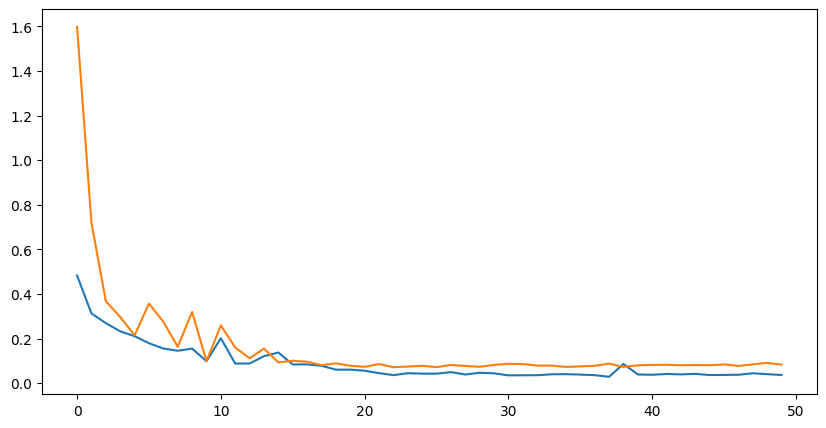

In [13]:
plt.figure(figsize= (10,5))
plt.plot(TrainLoss_list1)
plt.plot(val_losses)
#plt.show()

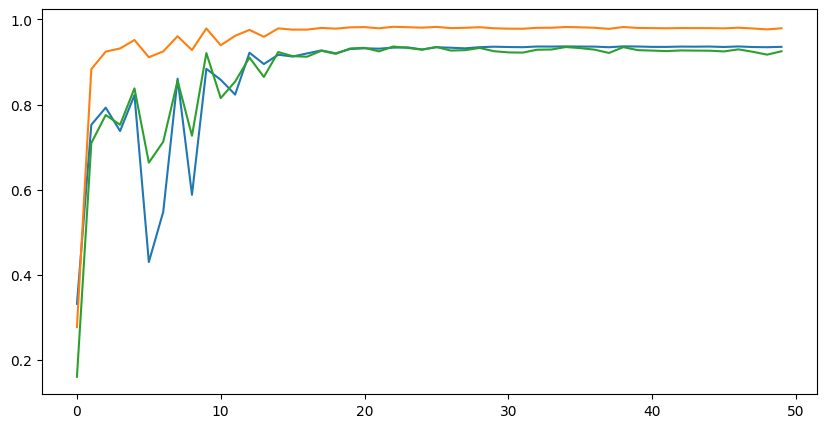

In [15]:
plt.figure(figsize= (10,5))
plt.plot(valScore_list1)
plt.plot(val_accs)
plt.plot(val_mious)